# Importing Libraries

In [ ]:
from utils import *
from normalizers import *
from FLPO import *
from viz import *
from UAV_Net import UAV_Net
from annealing import anneal
import pickle

# Defining UAV Net and Parameters

In [ ]:
drones = [
    ((10.0, 5.0), (45.0, 50.0), 0.7),  # Long distance, high charge
    ((3.0, 40.0), (50.0, 10.0), 0.5),  # Long distance, medium charge
    ((20.0, 15.0), (35.0, 35.0), 0.6),  # Moderate distance, medium charge
    ((5.0, 30.0), (25.0, 5.0), 0.4),  # Moderate distance, low charge
    ((40.0, 45.0), (10.0, 10.0), 0.8),  # Long distance, high charge
    ((30.0, 20.0), (5.0, 35.0), 0.6),  # Moderate distance, medium charge
    ((15.0, 10.0), (40.0, 40.0), 0.4),  # Moderate distance, low charge
    ((35.0, 5.0), (10.0, 45.0), 0.5),  # Long distance, medium charge
    ((25.0, 40.0), (20.0, 10.0), 0.7),  # Moderate distance, high charge
    ((45.0, 15.0), (5.0, 20.0), 0.3),  # Long distance, low charge
]


hexagon = create_block("hexagon", center=(30.0, 30.0), length=3.0, distortion="none")
square = create_block("square", center=(15.0, 25.0), length=3.5, distortion="rotated")
square = square[:1] + [(15.0, 25.0)] + square[1:]  # adding some nonconvexity
triangle = create_block(
    "triangle", center=(30.0, 10.0), length=2.0, distortion="skewed"
)
blocks = [hexagon, square, triangle]


N_stations = 3
init_ugv = np.repeat(
    np.array(
        [
            [0.5, 0.9],
        ]
    ),
    N_stations,
    axis=0,
)
fcr = 25.0  # Full Charge Range
ugv_factor = 0.0  # the cost factor for UGV transportation
distance = "euclidean"  # distance measure in the environment

beta_init = 1e-4  # initial beta value for the optimization.
beta_f = 1e4  # final beta value for the optimization
alpha = 2.0  # beta growth rate
purturb = 1e-6  # random purturbation in optimization


uav_net = UAV_Net(drones, N_stations, init_ugv, blocks, ugv_factor, fcr, distance)

UAV Network was successfully created.


# Annealing Loop

In [ ]:
obj = uav_net.objective
Y_s, Betas = anneal(
    obj,
    uav_net.stations,
    uav_net.bounds,
    beta_init,
    beta_f,
    alpha,
    purturb,
    "powell",
    True,
)

with open("Y_s", "wb") as fp:  # Pickling
    pickle.dump(Y_s, fp)
with open("Betas", "wb") as fp:  # Pickling
    pickle.dump(Betas, fp)

Beta: 1.00e-04  F.E.: -3.08319e+05
Beta: 2.00e-04  F.E.: -1.53769e+05
Beta: 4.00e-04  F.E.: -7.64946e+04
Beta: 8.00e-04  F.E.: -3.78581e+04
Beta: 1.60e-03  F.E.: -1.85403e+04
Beta: 3.20e-03  F.E.: -8.88210e+03
Beta: 6.40e-03  F.E.: -4.05992e+03
Beta: 1.28e-02  F.E.: -1.69549e+03
Beta: 2.56e-02  F.E.: -5.50049e+02
Beta: 5.12e-02  F.E.: -1.49011e+02
Beta: 1.02e-01  F.E.: 2.74009e+01
Beta: 2.05e-01  F.E.: 1.09384e+02
Beta: 4.10e-01  F.E.: 3.81125e+01
Beta: 8.19e-01  F.E.: 4.52794e+01
Beta: 1.64e+00  F.E.: 4.79354e+01
Beta: 3.28e+00  F.E.: 4.91481e+01
Beta: 6.55e+00  F.E.: 4.95402e+01
Beta: 1.31e+01  F.E.: 4.97479e+01
Beta: 2.62e+01  F.E.: 4.97680e+01
Beta: 5.24e+01  F.E.: 4.97682e+01
--Optimization Terminated--
Elapsed time: 56.07


# Loading Optimized Parameters

In [3]:
# with open("Y_s_alpha_10", "rb") as fp:   
#     Y_s = pickle.load(fp)
# with open("Betas", "rb") as fp:   
#     Betas = pickle.load(fp)

# Getting the Routes

In [ ]:
uav_net.return_stagewise_cost(Y_s[-1], Betas[-1])
P_ss = calc_associations(uav_net.D_ss, Betas[-1])
routes = calc_routs(P_ss)
print_routs(routes, N_stations)



Drone 1 --->f3 --->f1 --->[D1]
Drone 2 --->f2 --->f3 --->f1 --->[D2]
Drone 3 --->f3 --->[D3]
Drone 4 --->f2 --->f3 --->[D4]
Drone 5 --->f1 --->f3 --->[D5]
Drone 6 --->f3 --->f2 --->[D6]
Drone 7 --->f3 --->f1 --->[D7]
Drone 8 --->f3 --->f2 --->[D8]
Drone 9 --->f2 --->[D9]
Drone 10 --->f1 --->f3 --->[D10]

# Visualization

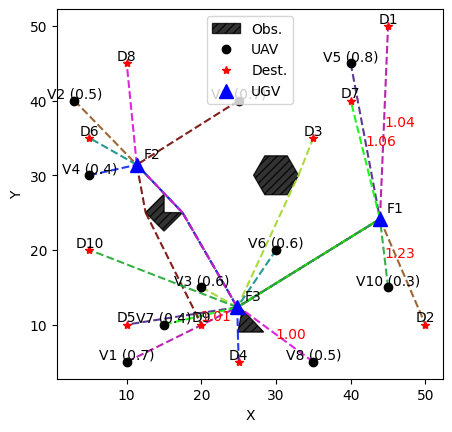

In [ ]:
from matplotlib import pyplot as plt

scale = uav_net.ub - uav_net.lb
drift = uav_net.lb
f_s = Y_s[-1] * scale + drift
plot_drone_routes(
    drones, f_s, blocks, routes, fcr, ugv_factor, ugv_init_loc=None, save_=False
)

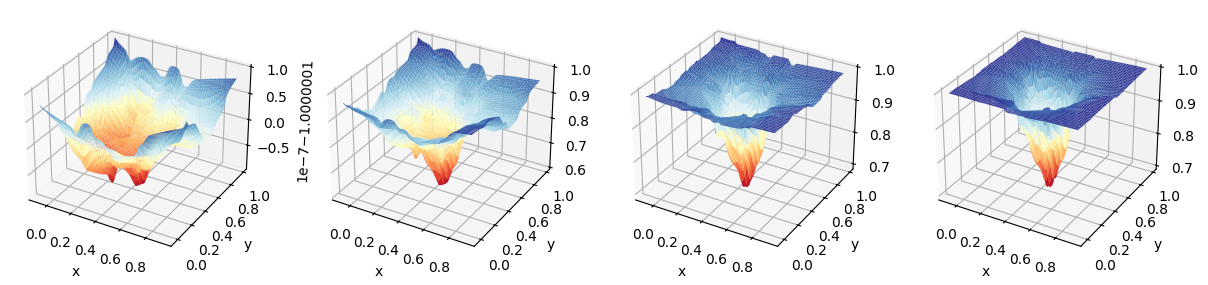

In [ ]:
r = 0.5
res = 250
params_opt = Y_s[-1].ravel()
Betas = [1e-8, 2e-2, 10e-2, 1e8]
fig = plt.figure(figsize=(15, 5))
xx = np.linspace(params_opt[0] - r, params_opt[0] + r, res)
yy = np.linspace(params_opt[1] - r, params_opt[1] + r, res)
X, Y = np.meshgrid(xx, yy)
for i, beta in enumerate(Betas):
    Z = np.zeros_like(X)
    for x_idx, x in enumerate(xx):
        for y_idx, y in enumerate(yy):
            # Create an array with all parameters set to their corresponding value in 'params_opt'
            # Compute the function value with these parameters
            Z[x_idx, y_idx] = uav_net.objective(np.array([x, y]), beta)

    ax = fig.add_subplot(1, 4, i + 1, projection="3d")
    # Plot the surface
    Z = Z / np.abs(Z.max())
    surf = ax.plot_surface(X, Y, Z, cmap="RdYlBu", edgecolor="none", antialiased=True)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    # ax.zaxis.get_major_formatter().set_useOffset(False)
    # ax.zaxis.get_major_formatter().set_scientific(False)

plt.savefig("Annealing.pdf")